# OM data prepocessing

## About OM

 This code uses the processed images from XMM-Newton's **Opical Monitor**. The images are **diffraction-limited** and each of the 5 exposures per filter are sub-windows covering 92% of the 17'x17' FOV (*2048x2048* pixels). The windows are stacked (2048x2048) and rebinned to **256x256** for computational efficiency. 
 
 Information about the configuration of the OM (e.g.: sub-windows stacking) can be found here: https://www.mssl.ucl.ac.uk/www_xmm/ukos/onlines/uhb/XMM_UHB/node62.html

## Input and mount data



In [2]:
import os
!pip install astropy
import matplotlib.pyplot as plt
# !pip install roboflow 
from roboflow import Roboflow
import csv
import cv2
from PIL import Image
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from astropy.visualization import ZScaleInterval, ImageNormalize

# this is needed to reload changes from imported modules, without the need to restart the kernel
from importlib import reload
import astronomy_utils
reload(astronomy_utils)
from astronomy_utils import *

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
OM_dir =  "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/"
OM_dir

'/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/'

## Roboflow data mounting

In [ ]:
# dir_ = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/"

# img = Image.open(dir_+segmented_dir_name+"S0300880101_U_segmented.png")
# print(np.array(img).shape)
# img.show()

# img = Image.open(dir_+raw_dir_name+"S0300880101_U.png")
# print(np.array(img).shape)
# img.show()

# Optical Monitor images

## Filling missing (-1) pixels with distributions

### Fill Poisson Localised

> We fill out bad pixels and detector gaps by the simulated Poisson
counts with the expected value of a local mean, calculated as the
mean of pixel values within a box of 15 × 15 pixels around a given
position. In case the fraction of masked pixels within that box is more
than 30%, the wider box is taken. This procedure is repeated until all
masked pixels are filled out.

In [ ]:
# create clusters of points, 
# these clusters are themselves distributed according to a Poisson process,
# within each cluster, points are normally distributed

def thomas(mu, sigma, nu, size=1):
    """
    Generate Thomas distributed random numbers.
    mu: mean of the clusters
    sigma: standard deviation within clusters
    nu: mean number of points per cluster
    size: number of random numbers to generate
    """
    num_clusters = np.random.poisson(nu, size)
    
    # Generate Thomas distributed numbers
    result = []
    for clusters in num_clusters:
        for _ in range(clusters):
            result.append(np.random.normal(mu, sigma))
    
    return np.array(result)

In [ ]:
# checking image histograms for gaussian threshold_sigma

def image_histogram(data_array):
    
    # Calculate the histogram
    hist, bins = np.histogram(data_array, bins=50)
    
    # Plot the histogram
    plt.hist(data_array, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
def rescale(value, old_min, old_max, new_min, new_max):
    return (value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

In [ ]:
from scipy.signal import fftconvolve
import matplotlib.image as mpimg
from PIL import Image
from scipy.ndimage import gaussian_filter

def fill_localised(input_array, distribution = 'poisson', size_input=2):
    """
    Fills all masked elements of an array with poisson/gaussian signal with local expected value.
    """
    array = np.ma.masked_less(input_array, 0)
   
    if not (isinstance(array, np.ma.MaskedArray)):
        print('No mask found')
        return input_array
    size = size_input
    output = array.data.copy()
    mask = array.mask.copy()
    mask_full = np.ones(mask.shape)
    
    # print(mask.sum())
    while mask.sum() > 1:
        kernel = np.ones((size, size))/size**2 #creates a kernel of ones with shape (size, size) normalized by size**2.
        coeff_full = fftconvolve(mask_full, kernel, mode='same')
        coeff = fftconvolve(np.logical_not(mask), kernel, mode='same') / coeff_full
        mean = fftconvolve(output, kernel, mode='same')
        
        # compute stdev
        diff = output - mean
        sq_diff = fftconvolve(diff**2, kernel, mode='same')
        sq_diff = np.clip(sq_diff, 0, None)
        std_dev = np.sqrt(sq_diff)
        norm_ = data_norm(mean[mean>=0])
        # plt.figure(figsize=(3,3)) 
        # plt.imshow(mean, cmap='gray', norm=norm_)
        # plt.axis('off')
        # plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        # plt.show()
        idx = np.where(np.logical_and(mask, coeff > 0.5))
        lambda_ = np.abs(mean[idx]/coeff[idx])
        std = np.abs(std_dev[idx]/coeff[idx])
        
        if distribution == 'poisson':
            output[idx] = np.abs(np.random.poisson(lambda_))
        if distribution == 'gaussian':
            output[idx] = np.abs(np.random.normal(lambda_, std))/8
        # print(f'Lambda: {output[idx]}')
        # print(f'Output --- Min: {min(output[idx])}, Max: {max(output[idx])}, Mean: {np.mean(output[idx])}, Var: {np.var(output[idx])}')
        output[idx] = rescale(output[idx], 0, 1, np.min(output[idx]), np.max(output[idx]))
        if distribution == 'thomas':
            mu = np.mean(mean)  # Compute mu from mean array
            # print(len(output[idx]))
            output[idx] = thomas(mu, 1, 1, size=3183)
        mask[idx] = False
        size += size_input
        size += (1 - size % 2)
    norm_ = data_norm(output)
    
    plt.figure() 
    plt.imshow(output, cmap='gray', norm=norm_)
    plt.axis('off')
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()
    return output
IMAGE_NAME = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/S0103060201_S.fits"
IMAGE_PATH = os.path.join(OM_dir,IMAGE_NAME)
original_image = fits.open(IMAGE_PATH)[0].data
output1 = fill_localised(original_image, 'gaussian')

In [ ]:
IMAGE_NAME = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/S0844260101_U.fits"
IMAGE_PATH = os.path.join(OM_dir,IMAGE_NAME)
original_image2 = fits.open(IMAGE_PATH)[0].data
original_image2 = original_image2
output2 = fill_localised(original_image2, 'gaussian')

In [ ]:
# This code highlights the negative pixels in an image in black
import matplotlib.image as mpimg
from PIL import Image
from scipy.ndimage import gaussian_filter

# IMAGE_NAME = "S0655570201_L.fits"
# IMAGE_PATH = os.path.join(OM_dir,IMAGE_NAME)
# original_image = fits.open(IMAGE_PATH)[0].data

# image_data = original_image.copy()

# image_data[image_data == -1] = np.nan
# image_data[image_data >=0 ] = 1
# fig, ax = plt.subplots(figsize=(60, 40))

# cax = ax.imshow(image_data, cmap='gray', vmin=0, vmax=1)

# cmap = plt.get_cmap('gray')
# cmap.set_bad(color='black', alpha=1.0)
# cax.cmap.set_bad(color='black', alpha=1.0)

# cbar = fig.colorbar(cax)

# # Display the plot
# plt.show()

In [ ]:
def threshold_sigma(image_array, sigma_):

    print("Computing sigma thresholding only for on-zero pixel image array:")
    mean_value = np.mean(image_array)
    std_dev = np.std(image_array)
    threshold = mean_value + sigma_ * std_dev
    print("\u03BC =", mean_value, "\u03C3 =", std_dev, f", threshold: \u03BC + {sigma_} * \u03C3:", threshold)
    
    # Extract the values within "sigma_" standard deviation
    values_within_3_sigma = []
    for i in range(len(image_array)):
            if(image_array[i] < threshold):
                values_within_3_sigma.append(image_array[i])

    return values_within_3_sigma

In [ ]:
# threshold_sigma(original_image[original_image>=0], sigma_=2)

In [ ]:
image_histogram(np.ndarray.flatten(original_image)) # should consider cutting the histogram due to outliers

In [ ]:
def fill_missing_data_with_distribution(fits_path, distribution='gaussian', seed=2):
    '''
    This selectively replace certain values in an array with random values from a Gaussian distribution for the negative pixels.
    '''
    # image_data = np.array(Image.open(image_path).convert("L"))  # Convert to grayscale
    hdul = fits.open(fits_path)

    #apparently, I need to flip the matrix horizontally, otherwise the output is mirrored.
    fits_data = hdul[0].data.copy() #* 1480

    fits_data = np.flipud(fits_data)
    hdul.close()

    # take only values at a sigma value (close to background) and non-zero
    valid_data = threshold_sigma(fits_data[fits_data>=0], sigma_ = 1)
    print("-----------------------------------")
    
    print("# negative pixels: ", np.count_nonzero(fits_data[fits_data==-1]))
    
    print("-----------------------------------")
    print("Fill missing data with distribution: ")
    if distribution == 'gaussian':
        mu = np.median(valid_data)
        sigma = np.std(valid_data)    # I took here a fraction, because otherwise it doesn't look natural
        generator = np.random.default_rng(0)
        filled_data = np.matrix(fits_data)
        num_rows, num_cols = filled_data.shape
        for i in range(num_rows):
            for j in range(num_cols):
                if(fits_data[i,j] < 0):
                    filled_data[i,j] = np.abs(generator.normal(mu, sigma))/1.05
                   
        return np.array(filled_data), mu, sigma

    elif distribution == 'poisson':
        lambda_ = np.mean(valid_data)
        print("Lambda:", lambda_)
        generator = np.random.default_rng(0)
        filled_data = np.matrix(fits_data)
        num_rows, num_cols = filled_data.shape
        for i in range(num_rows):
            for j in range(num_cols):
                if(fits_data[i,j] < 0):
                    filled_data[i,j] = generator.poisson(lambda_)
                   
        return np.array(filled_data), lambda_

    else:
        raise ValueError("Invalid distribution type")
    return None

OM_dir= '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
imgs = ['S0802200201_M.fits', 'S0673730101_U.fits', 'S0673350201_U.fits', 'S0304201401_U.fits', 'S0100240801_U.fits', 'S0302884001_M.fits']
for img_path in imgs:
    if img_path.endswith('.fits'):
        IMAGE_PATH = os.path.join(OM_dir,img_path)
        original_image = fits.open(IMAGE_PATH)[0].data.copy()
        original_image = np.flipud(original_image) # here flip the fits data
    
        print(original_image.shape)
    
        distr = 'gaussian'
    
        if distr == 'poisson':
            modified_image, lambda_ = fill_missing_data_with_distribution(IMAGE_PATH, distribution=distr)
            lambda_ = '%.3f'%lambda_
        if distr == 'gaussian':
            modified_image, mu, sigma = fill_missing_data_with_distribution(IMAGE_PATH, distribution=distr)
            mu = '%.3f'%mu
            sigma = '%.3f'%sigma
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))  
    
        # normalize image with ZScale considering only non-negative pixels
        norm_original = data_norm(original_image[original_image>=0])
        norm_modified = data_norm(modified_image[original_image>=0])
    
        axs[0].imshow(original_image, cmap="gray", norm=norm_original)
        axs[1].imshow(modified_image, cmap="gray", norm=norm_modified)
    
        axs[0].set_title(f'Zscaled image')
    
        output_image = f'{IMAGE_NAME.replace(".fits", "")}'
        if distr == 'poisson':
            axs[1].set_title(f'Filled image with Poisson distr., λ={lambda_}\n {IMAGE_PATH.split("/")[-1]}')
            output_image = output_image+"_poisson_plot.png"
        else:
            axs[1].set_title(f'Filled image with Gaussian distr., \n x͂={mu}, \u03C3={sigma}\n {IMAGE_PATH.split("/")[-1]}')
            output_image = output_image+"_gaussian_plot.png"
        print(np.min(modified_image), np.max(modified_image))

        # Apply zscale normalization only on non-negative data
        norm = data_norm(modified_image[modified_image>0])
        normalized_data = norm(modified_image)
        
        # Convert masked array to normal NumPy array
        normalized_data = normalized_data.filled(fill_value=-1)

        # clip to 255, because some pixels are very big
        scaled_data = np.clip((normalized_data * 255), 0, 255).astype(np.uint8)
        # scaled_data = 255 - scaled_data
        
        cv2.imwrite('./gaussian_distrib/'+img_path.replace('.fits', '.png'), 255-scaled_data)
        plt.show()
        plt.close()

# Zscale and save images


In [ ]:
# filename_ = OM_dir+"S0554500201_L.fits"
# img_ = zscale_image(filename_.replace("png", "fits"), '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/', with_image_stretch=True)

if 1==1:
    dir_files = [f for f in os.listdir(OM_dir) if os.path.isfile(os.path.join(OM_dir, f))]
    for file_ in dir_files:
        try:
            if file_.endswith("fits"):
                zscale_image(OM_dir+file_, OM_dir, with_image_stretch=False)
        except Exception as e:
            print(file_, e)
            pass

In [2]:
file_ = '/workspace/raid/OM_DeepLearning/XMM_OM_code_git/S0782500201_U.fits'
try:
    if file_.endswith("fits"):
        zscale_image(file_, '.', with_image_stretch=False)
except Exception as e:
    print(file_, e)
    pass

FITS file saved as PNG with zscale normalization: ./S0782500201_U.png


In [ ]:
OM_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'

# CLAHE algorithm


```
Contrast Limited Adaptive Histogram Equalization
```


(https://www.mathworks.com/help/visionhdl/ug/contrast-adaptive-histogram-equalization.html)


When Clip Limit (CL) is increased, the image becomes brighter because the input image has a very low intensity and a larger CL makes its histogram flatter. As the Block Size (BS) increases, the dynamic range expands, and the image contrast increases. The two parameters determined at the point of maximum entropy curvature produce subjectively good image quality when using image entropy. (https://www.analyticsvidhya.com/blog/2022/08/image-contrast-enhancement-using-clahe/)

If using a binary threshold, OTSU is the best way to find the best value. If necessary, K-means can be used.


There are two parameters to remember when using CLAHE:

clipLimit – This parameter controls the contrast limiting threshold. The default setting is 40.

tileGridSize – Determines the number of tiles in each row and column. This is set to 88 by default. It is applied while the image is divided into tiles for CLAHE.


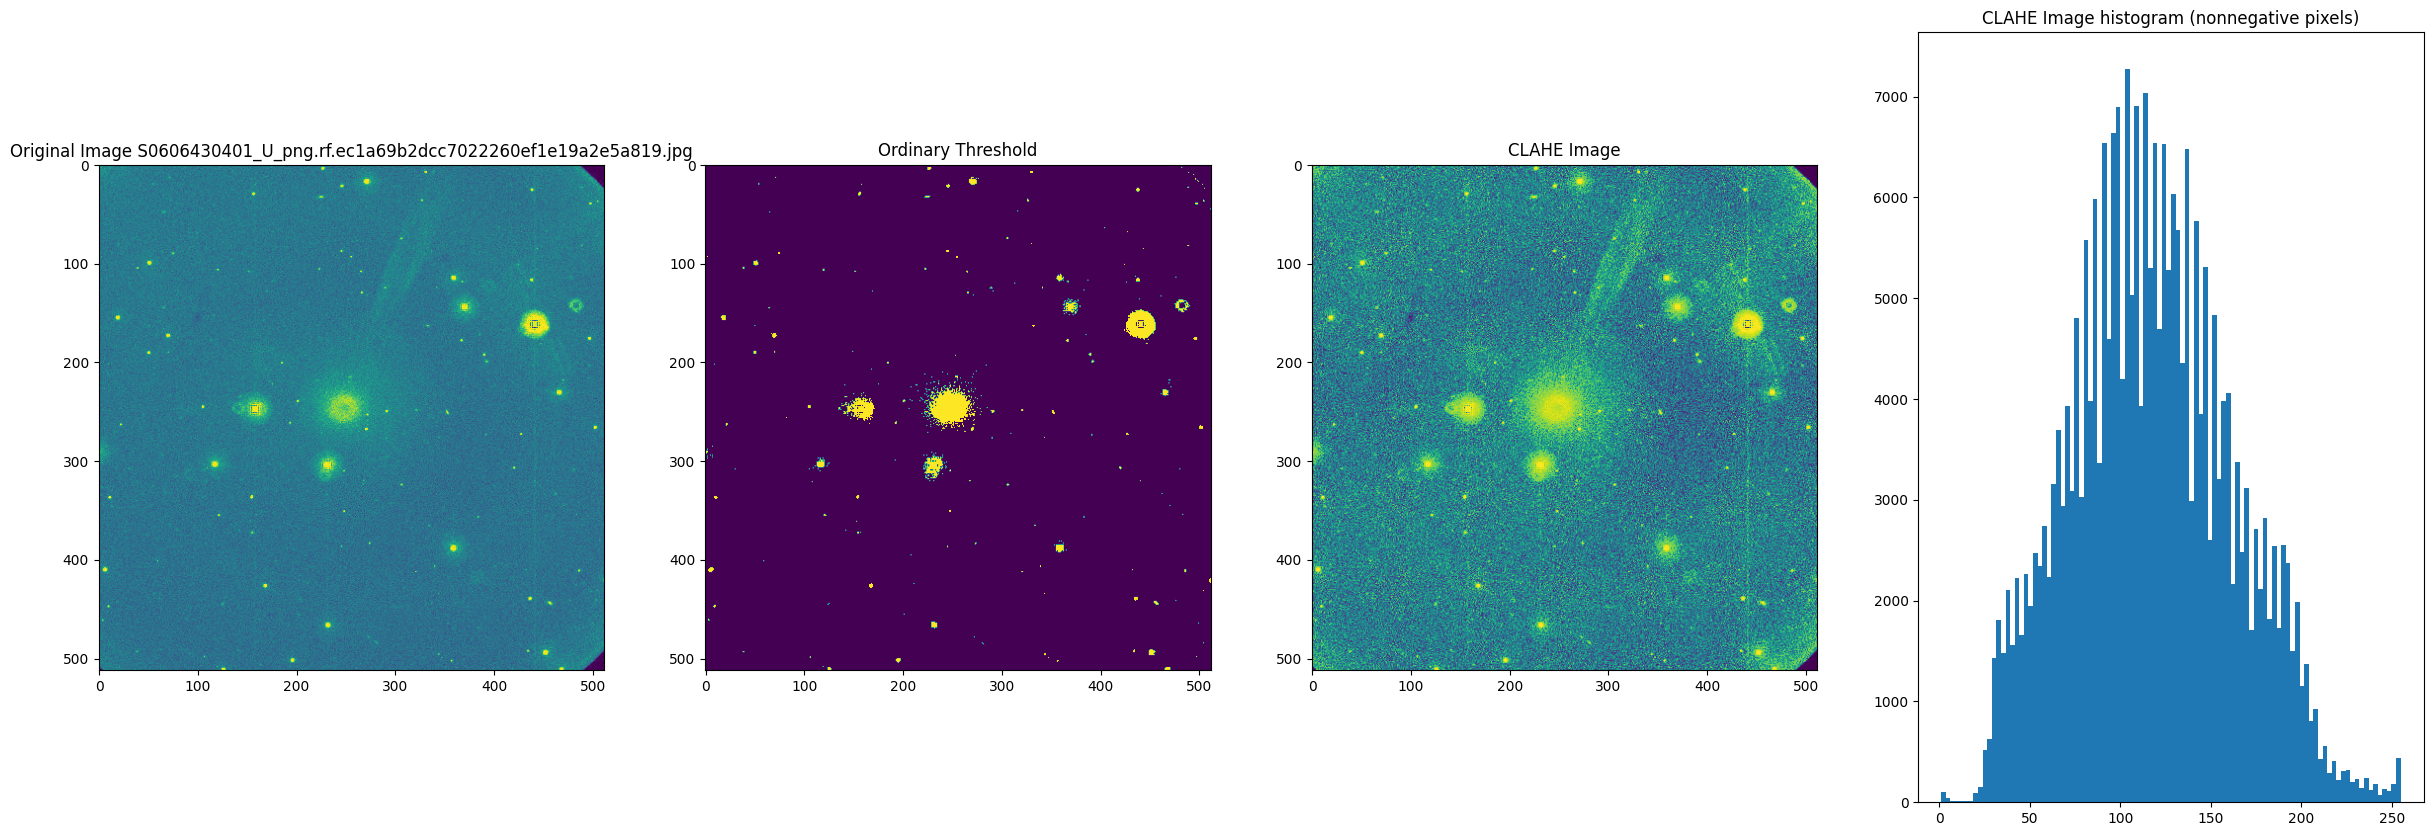

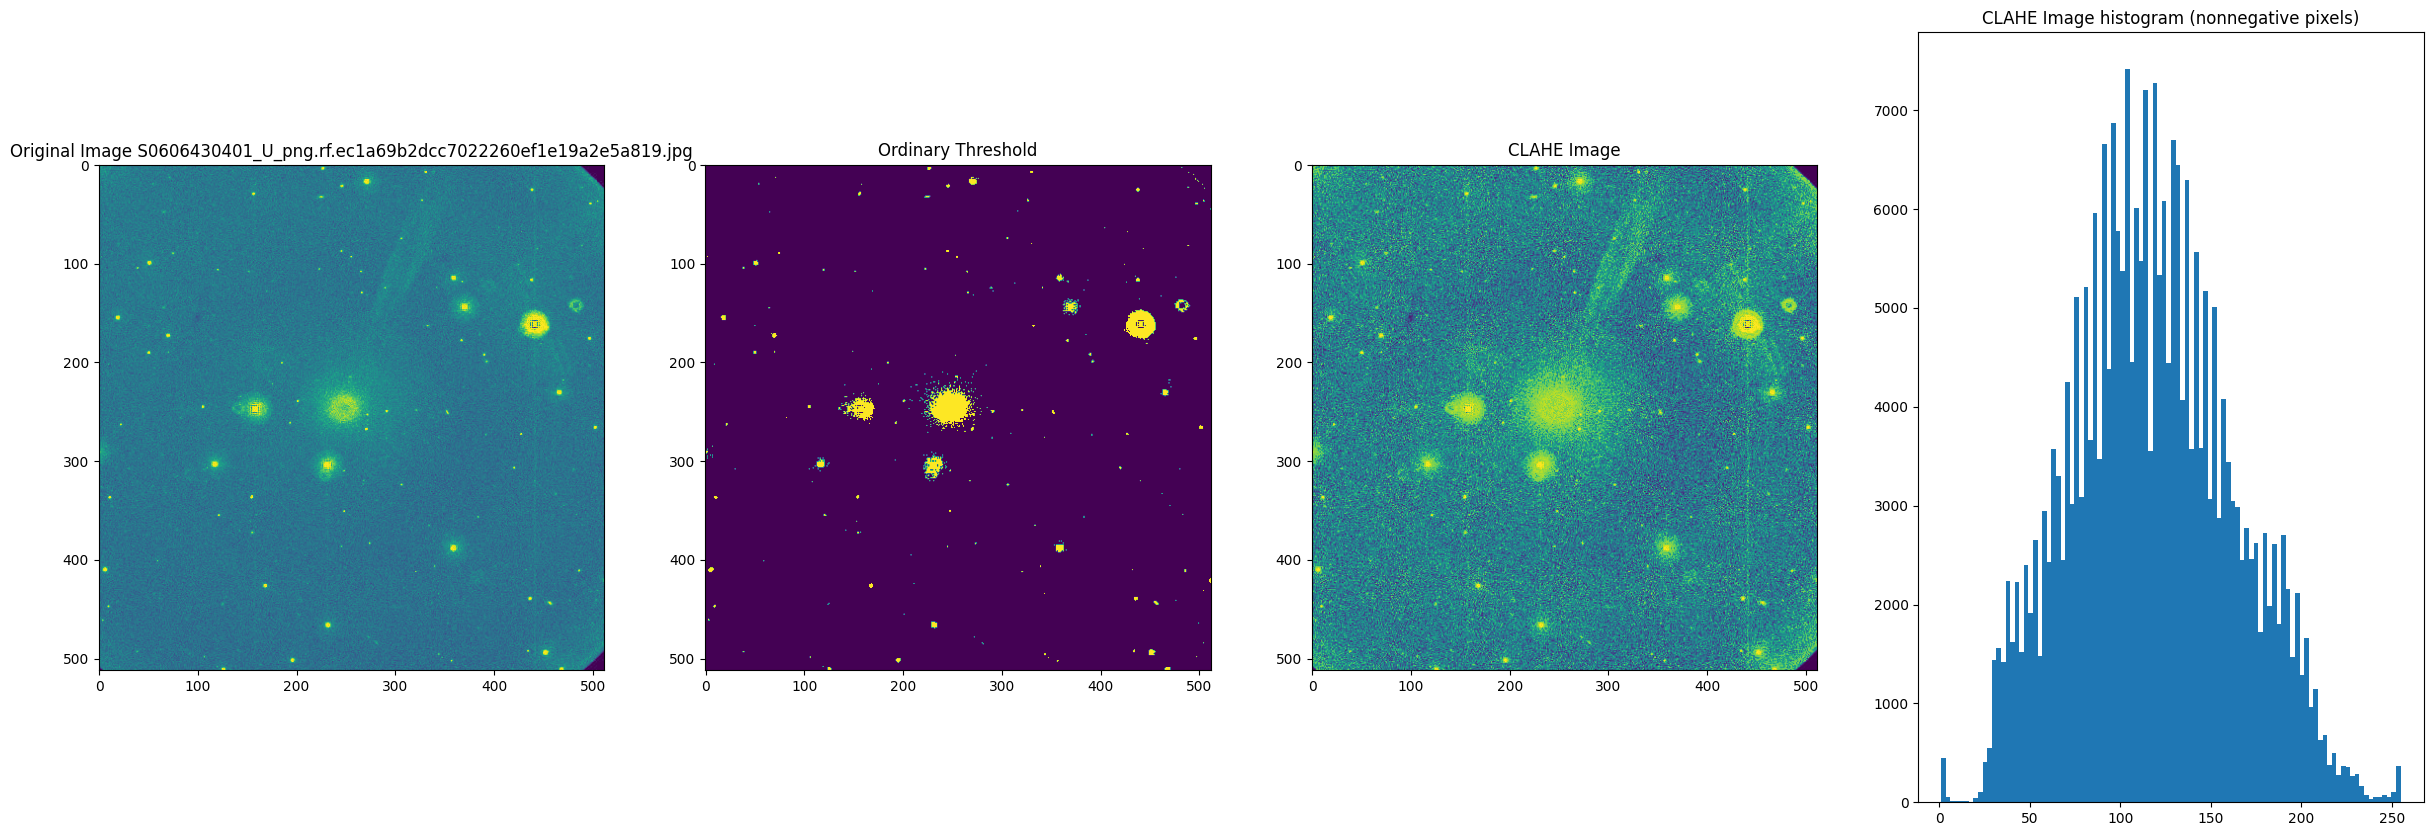

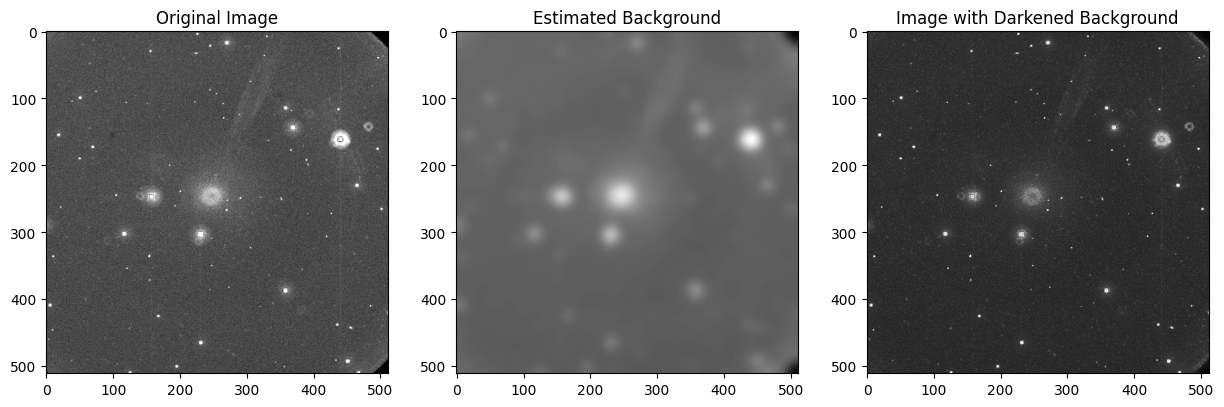

In [36]:
import matplotlib
from importlib import reload
import astronomy_utils
reload(astronomy_utils)
from astronomy_utils import *

in_dir = './xmm_om_images_v4-contrast-512-5-7/train/'
file_name = 'S0606430401_U_png.rf.ec1a69b2dcc7022260ef1e19a2e5a819.jpg'

if True:
# for file_name in os.listdir(in_dir):
    if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
        final_img = clahe_algo_image(in_dir+file_name, clipLimit=3.0)
        cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # mneh
        
if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
        final_img = clahe_algo_image_improved(in_dir+file_name, clipLimit=3.0)
        cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # mneh
    
# if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
#         final_img = enhance_contrast_with_adaptive_thresholding(in_dir+file_name, clipLimit=3.0)
#         cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # bad
    
# enhance_astronomical_image('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.fits') # bad
# selective_clahe_astronomical_image('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.fits') # bad
darken_background('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.png') 

# 3D Gaussian over image


In [ ]:
%matplotlib widget

image_2d = plt.imread("/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/S0111160201_V.png")
x = np.arange(image_2d.shape[0])
y = np.arange(image_2d.shape[1])
# alpha = np.ones(x.shape)

x, y = np.meshgrid(x, y)
# alpha = 1

# z = image_2d[:, :, 0] * alpha + image_2d[:, :, 1] * (1 - alpha)
z = image_2d

# Create a single subplot
fig = plt.figure(figsize=(13, 6))

# Add the first subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(y, x, z, cmap='viridis')

# Add the second subplot
ax2 = fig.add_subplot(122)
ax2.imshow(image_2d, cmap='gray')

ax1.set_xlabel('y')
ax1.set_ylabel('x')
ax1.set_zlabel('z')
ax1.set_title('3D image (z=pixels intensity)')

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D original image')
plt.subplots_adjust(wspace=0.1)
plt.show()
# plt.close()

# Wavelet methods

Paper: https://arxiv.org/abs/2310.10516

source code: http://heagit.cosmos.ru/nustar/nuwavdet


This code works on python > 3.10. 

In [12]:
# !git clone http://heagit.cosmos.ru/nustar/nuwavdet.git

Cloning into 'nuwavdet'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 267 (delta 126), reused 219 (delta 101), pack-reused 0
Receiving objects: 100% (267/267), 11.10 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [5]:
!pip show PyWavelets

In [6]:
import sys
print(sys.executable)


/opt/conda/envs/env_py311/bin/python


Python 3.11.7
[[False False]
 [False  True]
 [ True False]
 [ True  True]]
<class 'numpy.ndarray'>


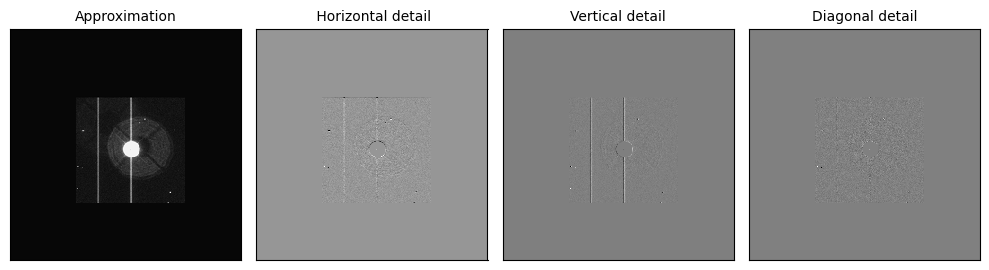

False


In [11]:
!python3 --version

import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/XMM_OM_code_git/nuwavdet/')
import nuwavdet

os.readlink('/proc/%d/exe' % os.getppid())
from nuwavdet import nuwavdet as nw
print(nw.binary_array(2))

import pywt
import pywt.data

original_filename = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/S0740140401_M.png"
# Load image
original = plt.imread(original_filename)
print(type(original))

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(10, 20))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# !pip install scipy==1.9.1 --upgrade
def atrous(level=0, max_size = 1001):
    """
    Returns a trous kernel with the size 2**level and corresponding shape.
    """
    base = 1/256*np.array([
        [1,  4,  6,  4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1,  4,  6,  4, 1],
    ])
    size = 2**level * (base.shape[0]-1)+1
    output = np.zeros((size, size))
    output[::2**level, ::2**level] = base
    if output.shape[0] > max_size:
        return output[(size-1)//2-(max_size-1)//2:(size-1)//2+(max_size-1)//2+1,
                      (size-1)//2-(max_size-1)//2:(size-1)//2+(max_size-1)//2+1]
    return output
def atrous_sig(level: int = 0) -> float:
    # sig_values = [0.8908, 0.20066, 0.08551, 0.04122, 0.02042]
    sig_values = [0.8725, 0.1893, 0.0946, 0.0473, 0.0237]
    if level < 5:
        return sig_values[level]
    else:
        return sig_values[4]/2**(level-4)
def gauss(level: int = 0, max_size: int = 1000) -> list[list[float]]:
    """
    Returns gaussian kernel with sigma = 2**level
    """
    size = min(5*2**(level+1)+1, max_size)
    sigma = 2**(level)
    A = 1/(2*np.pi*sigma**2)**0.5
    x = A*np.exp((-(np.arange(size)-(size-1)//2)**2)/(2*sigma**2))
    out = np.multiply.outer(x, x)
    return out

from scipy.signal import fftconvolve

def adjecent(array):
    """
    Returns two lists of indices of cells adjecent or diagonal to non-zero cells of given array
    """
    grid = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])
    output = fftconvolve(array, grid, mode='same') >= 0.5
    try:
        output = np.logical_and(np.logical_and(output, np.logical_not(array)),
                                np.logical_not(array.mask))
    except AttributeError:
        output = np.logical_and(output, np.logical_not(array))
    return output

def fill_poisson(array_input, size_input=15):
    from numpy import ma
    """
    Fills all masked elements of an array with poisson signal with local expected value.
    """
    array = ma.masked_array(array_input)
    if not (isinstance(array, np.ma.MaskedArray)):
        print('No mask found')
        return array
    size = size_input
    output = array.data.copy()
    mask = array.mask.copy()

    print(mask)
    mask_full = np.ones(mask.shape)
    while mask.sum() > 1:
        kernel = np.ones((size, size))/size**2
        coeff_full = fftconvolve(mask_full, kernel, mode='same')
        coeff = fftconvolve(np.logical_not(mask), kernel, mode='same') / coeff_full
        mean = fftconvolve(output, kernel, mode='same')
        idx = np.where(np.logical_and(mask, coeff > 0.7))
        output[idx] = np.random.poisson(np.abs(mean[idx]/coeff[idx]))
        mask[idx] = False
        size += size_input
        size += (1 - size % 2)
    return output
poisson_ = fill_poisson(original)

# norm_poisson = data_norm(poisson_[poisson_>=0])
# plt.imshow(poisson_, cmap="gray", norm=norm_poisson)
# plt.axis('off')
# plt.savefig('gaussian_.png')
# plt.show()

# !pip install opencv-python-headless
import numpy as np
import cv2
from scipy.signal import convolve
img = cv2.imread(original_filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the wavelet filter
wavelet_filter = np.array([[1, 4, 6, 4, 1],
                           [4, 6, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 6, 24, 16, 4],
                           [1, 4, 6, 4, 1]]) / 256

# Compute the wavelet coefficients at each scale
wavelet_coefficients = []
for i in range(3):
    wavelet_coefficients.append(convolve(gray, wavelet_filter, mode='same'))

# Upsample the wavelet coefficients at each scale
upsampled_wavelet_coefficients = []
for i in range(3):
    upsampled_wavelet_coefficients.append(cv2.resize(wavelet_coefficients[i], (img.shape[1], img.shape[0])))

# Reconstruct the image at each scale
reconstructed_images = []
for i in range(3):
    reconstructed_image = gray + upsampled_wavelet_coefficients[i]
    reconstructed_images.append(reconstructed_image)
final_image1 = np.zeros_like(img)
final_image2 = np.zeros_like(img)
final_image3 = np.zeros_like(img)

final_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)


for x in range(final_image.shape[0]):
    for y in range(final_image.shape[1]):
        for z in range(final_image.shape[2]):
            final_image1[x][y][z] = final_image1[x][y][z] + reconstructed_images[0][x][y] # Idk if this is really OK
            final_image2[x][y][z] = final_image2[x][y][z] + reconstructed_images[1][x][y] # Idk if this is really OK
            final_image3[x][y][z] = final_image3[x][y][z] + reconstructed_images[2][x][y] # Idk if this is really OK
                
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec1.png", final_image1)
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec2.png", final_image2)
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec3.png", final_image3)

# Find which files are from the same observation

In [ ]:
import os

folder_path = OM_dir
file_groups = {}

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    if os.path.isfile(file_path) and filename.endswith("png"):
        key = filename[1:11] # afaik, an OM obs id has the same first 11 characters for any filter
        if key in file_groups:
            file_groups[key].append(file_path)
        else:
            file_groups[key] = [file_path]

for key, files in file_groups.items():
    if len(files) >=2:
        print(f"Group '{key}':")
        for file in files:
            print(f"  {file}")
